# 2019 Kaggle ML & DS Survey Analysis
## Sam Weinberg (sam.weinberg@mail.utoronto.ca)
## 02/03/2020

This notebook analyzes the 2019 Kaggle ML and DS Survey results (https://www.kaggle.com/c/kaggle-survey-2019/). The goal was to determine some of the key attributes and skills of current data scientists, and how they correlate with salary. The benefit was 2-fold: I gained experience through data cleaning, exploration, visulation and analysis, and also determined which skills were most in demand for future studies. 

In [58]:
# First we load in the data from Kaggle_Salary.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline


salaries = pd.read_csv('Kaggle_Salary.csv')
salaries.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


## 1. Data Cleaning & 2. Exploratory Data Analysis

### The first component of this assignment is to clean the data, which includes handling of null entries and encoding categorical data. We will use one-hot-encoding for unordered categorical data (i.e. countries, etc.) and label-encoding for categorical data that is ordered in some manner (i.e. age buckets, # of employees, etc.). For the label-encoding, we will create a dictionary for the encoding first and then use the .replace() method to change all the values.

### At the same time, we will be performing exploratory data analysis as we go through question-by-question. At least three figures are displayed with commentary describing the insights. We end with a correlation plot to visualize feature importance.

In [59]:
# Q1: We will encode the different age ranges. Since thiese categories are ordered, we will use label-encoding.
age_nums = {'18-21': 21, '22-24': 22, '25-29': 25, '30-34': 30, '35-39': 35, '40-44': 40, '45-49': 45, '50-54': 50, '55-59': 55, '60-69': 60, '70+': 70}
salaries.replace({'Q1': age_nums}, inplace = True)

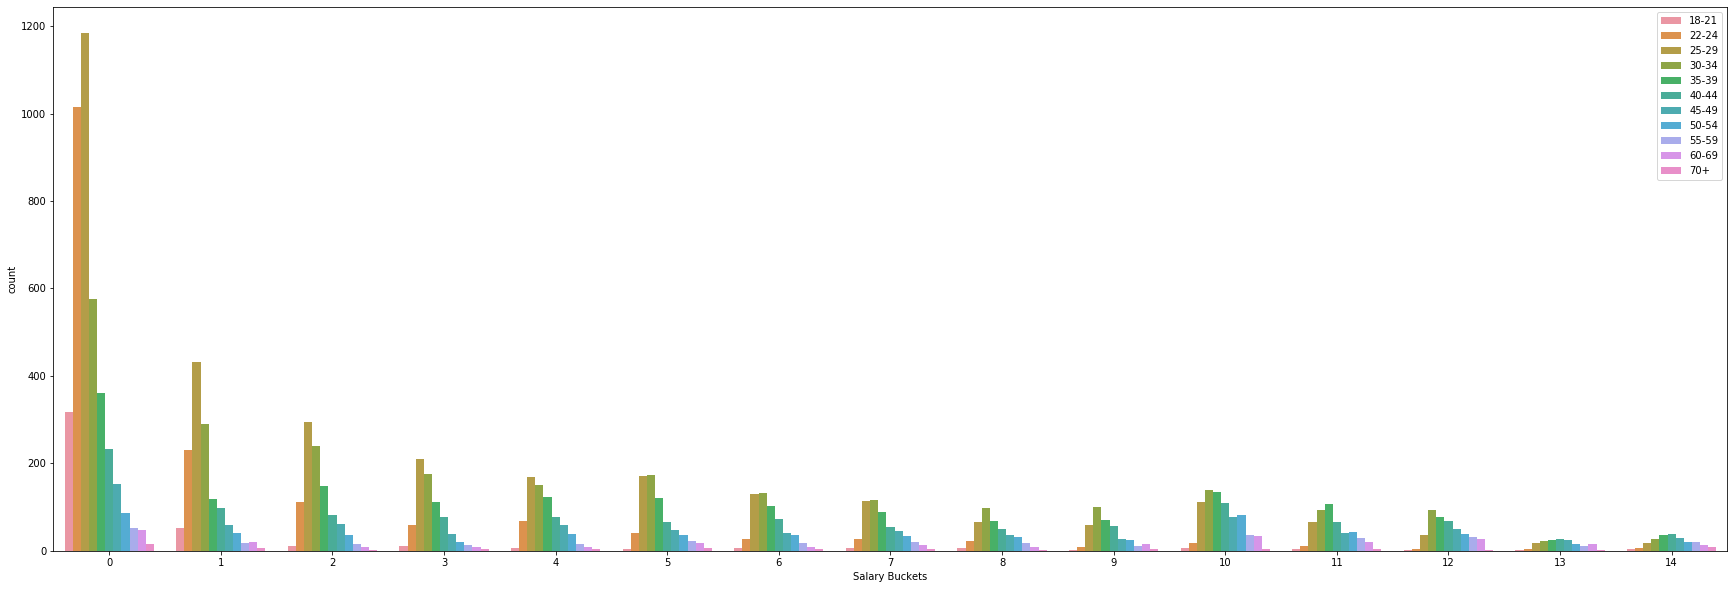

In [60]:
# We can plot the number of people within each age bucket at each salary level
fig = plt.figure(figsize=(30,10))
ax = sns.countplot(x = 'Q10_Encoded', hue='Q1', data=salaries)
plt.xlabel('Salary Buckets')
plt.legend(age_nums.keys())

The plot above confirms some inuitive ideas. First, the lower salary buckets (especially the lowest) contain the majority of the survey samples. They also contain a disproportionate number of young data scientists. Converesly, the highest salary buckets contain by far the fewest number of people. However, the age ranges are more symmetrically distributed in these higher buckets. We may conclude that being young would be correlated with making less money, but being older does not necessarily gain too much insight. Let us investigate how school degrees impact the salary bucket.

Text(0.5, 0, 'Salary Buckets')

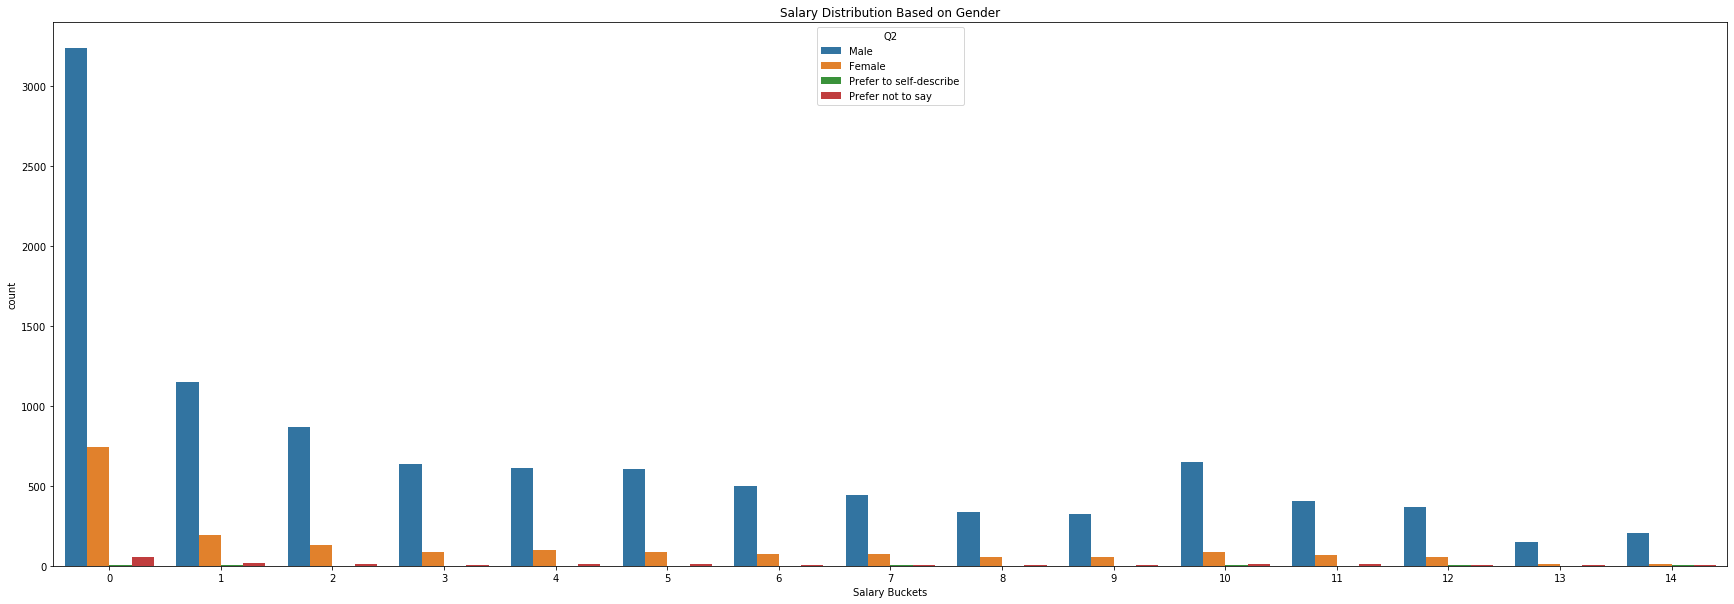

In [61]:
# We can plot the number of people within each gender at each salary level
fig = plt.figure(figsize=(30,10))
ax = sns.countplot(x = 'Q10_Encoded', hue='Q2', data=salaries).set_title('Salary Distribution Based on Gender')
plt.xlabel('Salary Buckets')

We notice that the majority of data scientists are male, and a large percentage of the higher salary buckets is composed of males.

In [62]:
# Q2: We encode gender using one-hot encoding as opposed to label encoding (i.e. 0, 1, 2, etc.).
# gender_nums = {"Male": 0, "Female": 1, "Prefer not to say": 2, "Prefer to self-describe": 3}
# This ensures that the model doesn't interpret the categorical data as ordered.
gender_dummies = pd.get_dummies(salaries.Q2, prefix = 'Q2')
salaries = salaries.join(gender_dummies)
salaries.drop(['Q2', 'Q2_OTHER_TEXT'], inplace = True, axis = 1)


In [63]:
salaries.Q3.unique()

array(['France', 'India', 'Australia', 'United States of America',
       'Netherlands', 'Germany', 'Ireland', 'Russia', 'Greece', 'Ukraine',
       'Pakistan', 'Japan', 'Other', 'Brazil', 'South Korea', 'Belarus',
       'Nigeria', 'United Kingdom of Great Britain and Northern Ireland',
       'Sweden', 'Mexico', 'Canada', 'Portugal', 'Poland', 'Indonesia',
       'Italy', 'Czech Republic', 'Spain', 'Chile', 'Hong Kong (S.A.R.)',
       'South Africa', 'Argentina', 'Turkey', 'Israel', 'Taiwan', 'Egypt',
       'Morocco', 'Hungary', 'Colombia', 'Norway', 'Thailand',
       'Switzerland', 'Viet Nam', 'Singapore', 'Bangladesh',
       'Iran, Islamic Republic of...', 'Peru', 'Kenya', 'Romania',
       'China', 'Belgium', 'Austria', 'Algeria', 'New Zealand', 'Tunisia',
       'Philippines', 'Malaysia', 'Republic of Korea', 'Denmark',
       'Saudi Arabia'], dtype=object)

In [64]:
# Q3: We encode country also using one-hot-encoding for the same reason as above.
country_dummies = pd.get_dummies(salaries.Q3, prefix = 'Q3')
salaries = salaries.join(country_dummies)
salaries.drop('Q3', inplace = True, axis = 1)


Text(0.5, 1.0, 'Salary Distribution in U.S.A.')

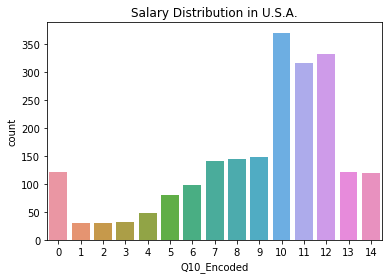

In [65]:
# Salary bucket distribution in the United States
sns.countplot(x = salaries[salaries['Q3_United States of America'] == 1].Q10_Encoded, data = salaries[salaries['Q3_United States of America'] == 1]).set_title('Salary Distribution in U.S.A.')

This plot shows that data scientists from America compose a significant portion of the upper salary buckets. We may be able to generalize this and hypothesize that developed nations generally will have high salaries than developing nations. Let's explore the same plot with India as the country.

Text(0.5, 1.0, 'Salary Distribution in India')

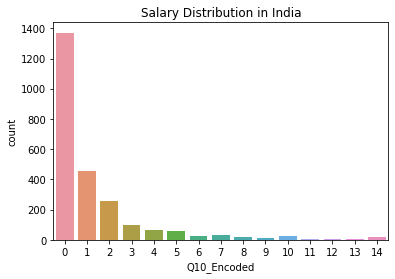

In [66]:
# Salary bucket distribution in the India
sns.countplot(x = salaries[salaries['Q3_India'] == 1].Q10_Encoded, data = salaries[salaries['Q3_India'] == 1]).set_title('Salary Distribution in India')

Here we see that India is negatively correlated with salary. Over 1300 survey responses from India appear in the first bucket, which is a significant portion of the entire survey. These plots demonstrate that country plays an important role in determining salary, especially if there are a large number of responses from that country to statistically confirm the correlation.

Text(0.5, 0, 'Salary Buckets')

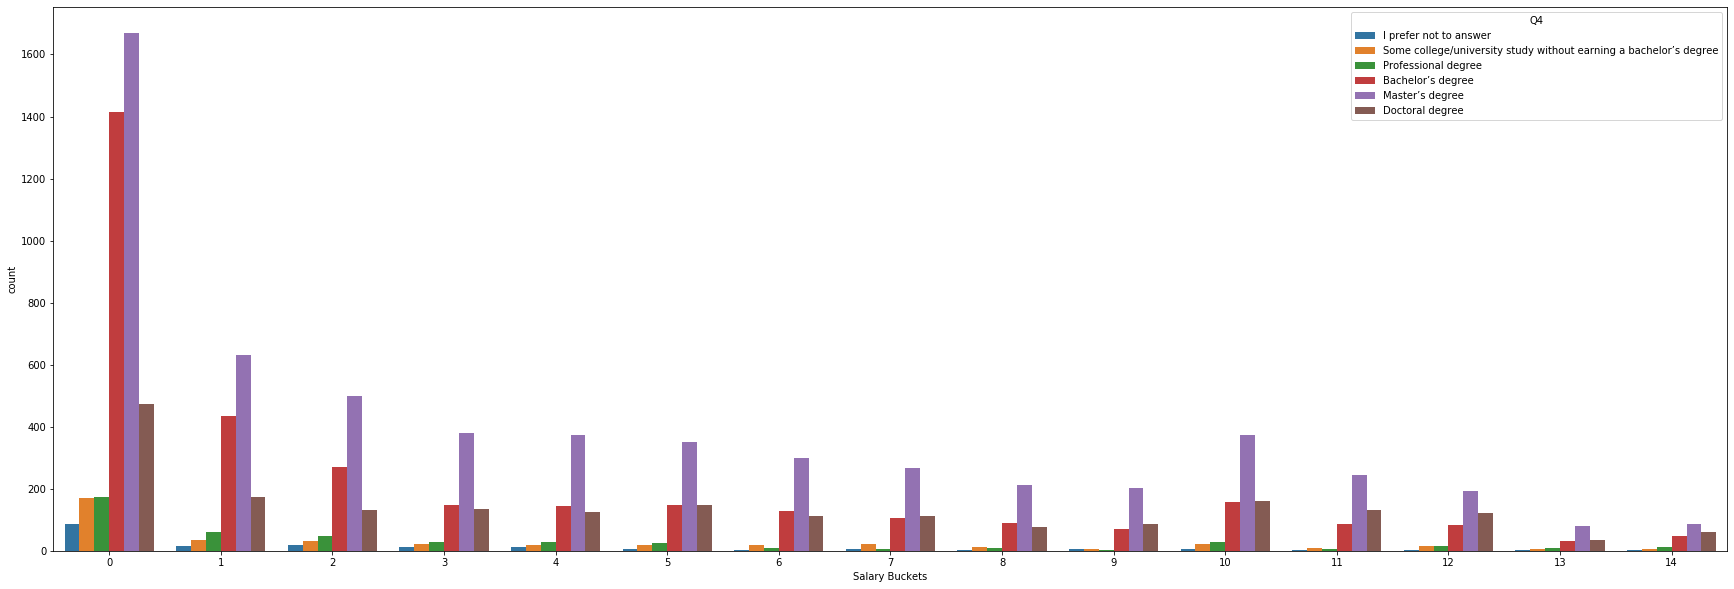

In [67]:
# We can plot the number of people with each educational background at each salary level
fig = plt.figure(figsize=(30,10))
ax = sns.countplot(x = 'Q10_Encoded', hue='Q4', data=salaries, hue_order = ['I prefer not to answer',
                                                                         'Some college/university study without earning a bachelor’s degree',
                                                                         'Professional degree',
                                                                         'Bachelor’s degree',
                                                                         'Master’s degree',
                                                                         'Doctoral degree'])
                                                                         
                                                                                                                       
                                                                        
plt.xlabel('Salary Buckets')

Here we can see that the majority of data scientists either possess a masters degree or bachelor's degree. As the salary buckets increase, we can see that the proportion of bachelor's degrees decreases while the proportion of PhD's increases. However, it is still unclear whether the degree is indicative of the salary bucket. We will explore the impact of countries n this outcome.

In [68]:
# Q4 we have oredered categorical data
salaries.Q4.unique()
degree_nums = {'No formal education past high school': 0, 
                  'I prefer not to answer': 0, 
                  'Some college/university study without earning a bachelor’s degree': 1,
                  'Bachelor’s degree': 2,
                  'Professional degree': 2,
                  'Master’s degree': 3,
                  'Doctoral degree': 4}
salaries.replace({'Q4': degree_nums}, inplace = True)


In [69]:
# Q5 we use one-hot-encoding.
job_dummies = pd.get_dummies(salaries.Q5, prefix = 'Q5')

salaries = salaries.join(job_dummies)
salaries.drop(['Q5', 'Q5_OTHER_TEXT'], inplace = True, axis = 1)

In [70]:
# Q6 and Q7 we have ordered categorical data (i.e. number of employees, number of in) so we return to using label encoding as follows.
employee_nums = {'0-49 employees': 0, '50-249 employees': 1, '250-999 employees': 2, '1000-9,999 employees': 3, '> 10,000 employees': 4}
Q7_nums = {'0': 0, '1-2': 1, '3-4': 2, '5-9': 3, '10-14': 4, '15-19': 5, '20+': 6}
salaries.replace({'Q6': employee_nums}, inplace = True)
salaries.replace({'Q7': Q7_nums}, inplace = True)

In [71]:
# Q8 is categorical data that doesn't use number range buckets, but I would still consider it ordered data.
# Based off my own interpretation of the available answers, the following label encoding was implemented.
salaries.Q8.unique()
MLmethods_nums = {'No (we do not use ML methods)': 0, 
                  'I do not know': 0, 
                  'We are exploring ML methods (and may one day put a model into production)': 1,
                  'We use ML methods for generating insights (but do not put working models into production)': 2,
                  'We recently started using ML methods (i.e., models in production for less than 2 years)': 3,
                  'We have well established ML methods (i.e., models in production for more than 2 years)': 4}

salaries.replace(MLmethods_nums, inplace = True)

In [72]:
# Q9 has 8 possible selections that are NOT mutually exclusive. The answers are essentially already one-hot-encoded.
# We must replace text values with 1, and nulls with 0 for each part.

Q9part1_nums = {'Analyze and understand data to influence product or business decisions': 1}
Q9part2_nums = {'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data': 1}
Q9part3_nums = {'Build prototypes to explore applying machine learning to new areas': 1}
Q9part4_nums = {'Build and/or run a machine learning service that operationally improves my product or workflows': 1}
Q9part5_nums = {'Experimentation and iteration to improve existing ML models': 1}
Q9part6_nums = {'Do research that advances the state of the art of machine learning': 1}
Q9part7_nums = {'None of these activities are an important part of my role at work': 1}
Q9part8_nums = {'Other': 1}

salaries.replace({'Q9_Part_1': Q9part1_nums, 'Q9_Part_2': Q9part2_nums, 'Q9_Part_3': Q9part3_nums, 'Q9_Part_4': Q9part4_nums,
                 'Q9_Part_5': Q9part5_nums, 'Q9_Part_6': Q9part6_nums, 'Q9_Part_7': Q9part7_nums, 'Q9_Part_8': Q9part8_nums}, 
                 inplace = True)

salaries = salaries.fillna(value = {'Q9_Part_1': 0, 'Q9_Part_2': 0, 'Q9_Part_3': 0, 'Q9_Part_4': 0,
                                    'Q9_Part_5': 0, 'Q9_Part_6': 0, 'Q9_Part_7': 0, 'Q9_Part_8': 0})

salaries.drop('Q9_OTHER_TEXT', inplace = True, axis = 1)



Text(0.5, 1.0, 'Distribution of Salary Buckets')

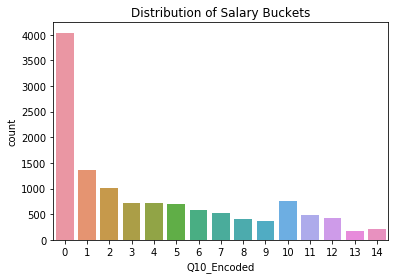

In [73]:
# Plot histogram of salary bucket counts
sns.countplot(x = 'Q10_Encoded', data = salaries).set_title('Distribution of Salary Buckets')

This plot simply shows that we have an imbalanced dataset, with the majority of responses belonging to the first salary bucket. We will consider this when cross validating the model.

In [74]:
salaries.Q11.unique()

array(['$0 (USD)', '> $100,000 ($USD)', '$10,000-$99,999', '$100-$999',
       '$1000-$9,999', '$1-$99', nan], dtype=object)

In [75]:
# Q11 we will use label encoding since the data is ordered. We also fill null values with zero since it is the most frequent response.
print('The most frequent response is {}, and its percentage of all the repsonses is {:0.3}%.'.format(salaries.Q11.describe().top, 100*salaries.Q11.describe().freq/salaries.Q11.describe()['count']))
Q11_nums = {'$0 (USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3, '$10,000-$99,999': 4, '> $100,000 ($USD)': 5}
salaries = salaries.fillna(value = {'Q11': 0})
salaries.replace({'Q11': Q11_nums}, inplace = True)

The most frequent response is $0 (USD), and its percentage of all the repsonses is 33.0%.


In [76]:
# Q12 has 12 parts. We will approach it the same as Q9 and fill text responses with 1's and nulls with 0's.
# Observing that several of the upcoming questions follow this format, I iterated through the different question parts
# to create the dictionary. Then we can use the .replace() method with the dictionary.

# This function can be used to one-hot-encode the n part responses in the survey. It creates a dictionary to be used within
# the .replace() method.
#
# Input: Question Number, Number of Responses
# Output: Dictionary

def encode12(q_num, response_num):
    temp = {} # Initiate dictionary
    
    for i in range(1,response_num + 1):
        part_num = str(q_num) + '_Part_' + str(i)
        temp[part_num] = {salaries[part_num][salaries[part_num].notna()].unique()[0]: 1}
        
    return temp
    
Q12_nums = encode12('Q12', 12)
salaries.replace(Q12_nums, inplace = True)
salaries = salaries.fillna(value = {'Q12_Part_1': 0, 'Q12_Part_2': 0, 'Q12_Part_3': 0, 'Q12_Part_4': 0,
                                    'Q12_Part_5': 0, 'Q12_Part_6': 0, 'Q12_Part_7': 0, 'Q12_Part_8': 0,
                                    'Q12_Part_9': 0, 'Q12_Part_10': 0, 'Q12_Part_11': 0, 'Q12_Part_12': 0})

salaries.drop('Q12_OTHER_TEXT', inplace = True, axis = 1)


In [77]:
Q12_nums

{'Q12_Part_1': {'Twitter (data science influencers)': 1},
 'Q12_Part_2': {'Hacker News (https://news.ycombinator.com/)': 1},
 'Q12_Part_3': {'Reddit (r/machinelearning, r/datascience, etc)': 1},
 'Q12_Part_4': {'Kaggle (forums, blog, social media, etc)': 1},
 'Q12_Part_5': {'Course Forums (forums.fast.ai, etc)': 1},
 'Q12_Part_6': {'YouTube (Cloud AI Adventures, Siraj Raval, etc)': 1},
 'Q12_Part_7': {'Podcasts (Chai Time Data Science, Linear Digressions, etc)': 1},
 'Q12_Part_8': {'Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)': 1},
 'Q12_Part_9': {'Journal Publications (traditional publications, preprint journals, etc)': 1},
 'Q12_Part_10': {'Slack Communities (ods.ai, kagglenoobs, etc)': 1},
 'Q12_Part_11': {'None': 1},
 'Q12_Part_12': {'Other': 1}}

In [78]:
# Q13 also has 12 parts with same format, so we will reuse code from Q12.
Q13_nums = encode12('Q13', 12)
salaries.replace(Q13_nums, inplace = True)
salaries = salaries.fillna(value = {'Q13_Part_1': 0, 'Q13_Part_2': 0, 'Q13_Part_3': 0, 'Q13_Part_4': 0,
                                    'Q13_Part_5': 0, 'Q13_Part_6': 0, 'Q13_Part_7': 0, 'Q13_Part_8': 0,
                                    'Q13_Part_9': 0, 'Q13_Part_10': 0, 'Q13_Part_11': 0, 'Q13_Part_12': 0})

salaries.drop('Q13_OTHER_TEXT', inplace = True, axis = 1)


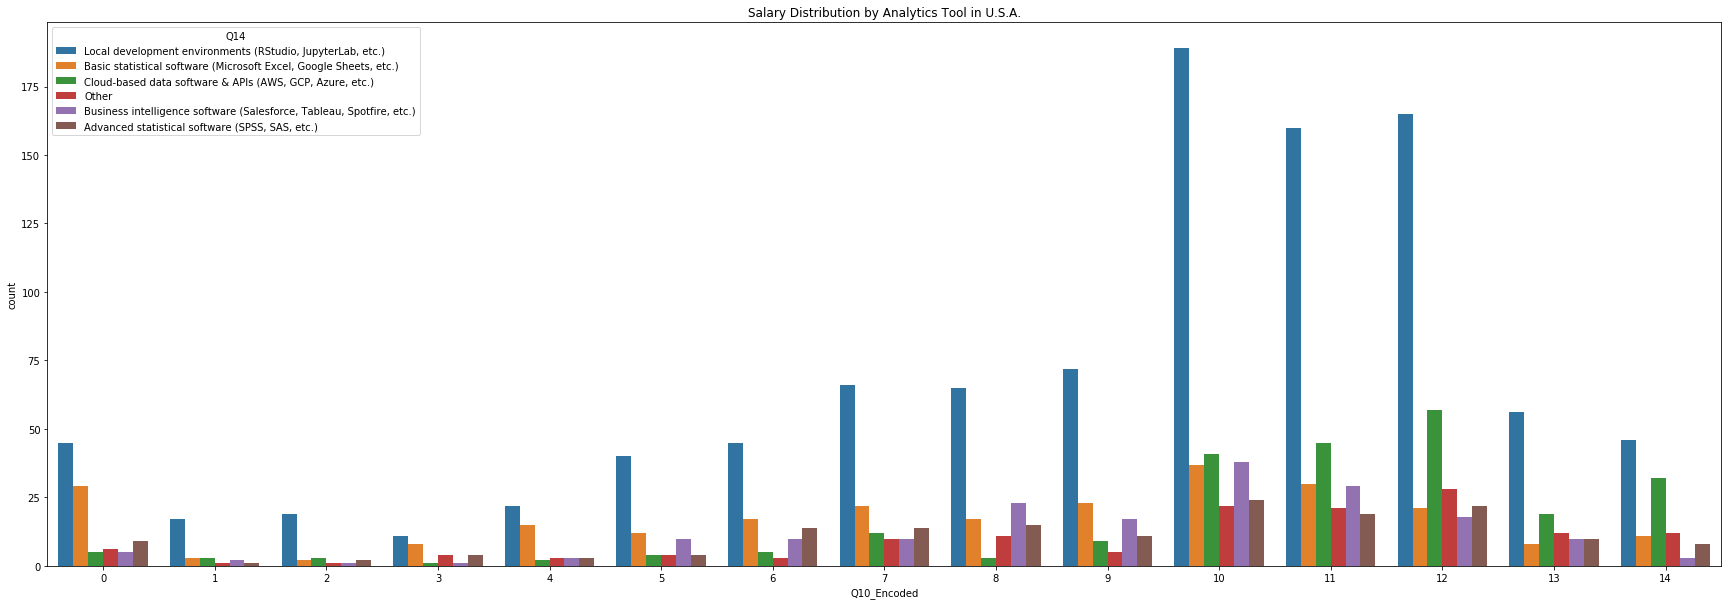

In [79]:
# Q14 Statistics
fig = plt.figure(figsize=(30,10))
ax = sns.countplot(x = salaries[salaries['Q3_United States of America'] == 1].Q10_Encoded, hue = salaries[salaries['Q3_United States of America'] == 1].Q14, data = salaries[salaries['Q3_United States of America'] == 1]).set_title('Salary Distribution by Analytics Tool in U.S.A.')

In [80]:
# Q14 we will use one-hot-encoding on the categorical data since it is unordered. We will drop the additional Q14_Part_x's
# since they correspond to text input that is unavailable to us. To replace NaNs, we have a couple options. One option is
# fill in the most frequent response, which is 'Local Development Environments'. Another option is that since the response
# was left blank, they probably don't use any of the above, in which case we could fill the nulls with 'None'. We will
# choose the second option and add an additional response 'None'. Note: It may have also been safe to assume that the company
# is at least using Excel, etc. if they aren't using Local Development Environments.
salaries = salaries.fillna(value = {'Q14': 'None'})
Q14_dummies = pd.get_dummies(salaries.Q14, prefix = 'Q14')
salaries = salaries.join(Q14_dummies)
salaries.drop(['Q14', 'Q14_Part_1_TEXT', 'Q14_Part_2_TEXT', 'Q14_Part_3_TEXT', 'Q14_Part_4_TEXT', 'Q14_Part_5_TEXT', 'Q14_OTHER_TEXT'], inplace = True, axis = 1)

In [81]:
# Q15 Statistics
salaries.Q15.describe()

count         11422
unique            7
top       3-5 years
freq           2818
Name: Q15, dtype: object

In [82]:
# Q15 is ordered categorical so we use label-encoding. We will fill nulss with the mode response.
salaries = salaries.fillna(value = {'Q15': salaries.Q15.describe().top})

Q15_nums = {'I have never written code': 0, '< 1 years': 1, '1-2 years': 2, '3-5 years': 5, '5-10 years': 10, '10-20 years': 20, '20+ years': 30}
salaries.replace({'Q15': Q15_nums}, inplace = True)


In [83]:
# Q16 has 12 parts, same format as Q12 so we will reuse the code.
Q16_nums = encode12('Q16', 12)
    
salaries.replace(Q16_nums, inplace = True)
salaries = salaries.fillna(value = {'Q16_Part_1': 0, 'Q16_Part_2': 0, 'Q16_Part_3': 0, 'Q16_Part_4': 0,
                                    'Q16_Part_5': 0, 'Q16_Part_6': 0, 'Q16_Part_7': 0, 'Q16_Part_8': 0,
                                    'Q16_Part_9': 0, 'Q16_Part_10': 0, 'Q16_Part_11': 0, 'Q16_Part_12': 0})

salaries.drop('Q16_OTHER_TEXT', inplace = True, axis = 1)

In [84]:
# Q17 has 12 parts, same format as Q12 so we will reuse the code.
Q17_nums = encode12('Q17', 12)
    
salaries.replace(Q17_nums, inplace = True)
salaries = salaries.fillna(value = {'Q17_Part_1': 0, 'Q17_Part_2': 0, 'Q17_Part_3': 0, 'Q17_Part_4': 0,
                                    'Q17_Part_5': 0, 'Q17_Part_6': 0, 'Q17_Part_7': 0, 'Q17_Part_8': 0,
                                    'Q17_Part_9': 0, 'Q17_Part_10': 0, 'Q17_Part_11': 0, 'Q17_Part_12': 0})

salaries.drop('Q17_OTHER_TEXT', inplace = True, axis = 1)

In [85]:
# Q18 has 12 parts, same format as Q12 so we will reuse the code.
Q18_nums = encode12('Q18', 12)
    
salaries.replace(Q18_nums, inplace = True)
salaries = salaries.fillna(value = {'Q18_Part_1': 0, 'Q18_Part_2': 0, 'Q18_Part_3': 0, 'Q18_Part_4': 0,
                                    'Q18_Part_5': 0, 'Q18_Part_6': 0, 'Q18_Part_7': 0, 'Q18_Part_8': 0,
                                    'Q18_Part_9': 0, 'Q18_Part_10': 0, 'Q18_Part_11': 0, 'Q18_Part_12': 0})

salaries.drop('Q18_OTHER_TEXT', inplace = True, axis = 1)

In [86]:
# Q19 Statistics
salaries.Q19.describe()

count      10653
unique        12
top       Python
freq        8200
Name: Q19, dtype: object

In [87]:
# Q19 is unordered categorical data. The majority of responses are 'Python', so we will fill null values with that response.
# We will use one-hot-encoding.
salaries = salaries.fillna(value = {'Q19': salaries.Q19.describe().top})
Q19_dummies = pd.get_dummies(salaries.Q19, prefix = 'Q19')
salaries = salaries.join(Q19_dummies)
salaries.drop(['Q19', 'Q19_OTHER_TEXT'], inplace = True, axis = 1)


In [90]:
# Q20 has 12 parts, same format as Q12 so we will reuse the code.
Q20_nums = encode12('Q20', 12)
    
salaries.replace(Q20_nums, inplace = True)
salaries = salaries.fillna(value = {'Q20_Part_1': 0, 'Q20_Part_2': 0, 'Q20_Part_3': 0, 'Q20_Part_4': 0,
                                    'Q20_Part_5': 0, 'Q20_Part_6': 0, 'Q20_Part_7': 0, 'Q20_Part_8': 0,
                                    'Q20_Part_9': 0, 'Q20_Part_10': 0, 'Q20_Part_11': 0, 'Q20_Part_12': 0})

salaries.drop('Q20_OTHER_TEXT', inplace = True, axis = 1)

ValueError: Replacement not allowed with overlapping keys and values

In [91]:
# Q21 has 5 parts, same format as Q12 so we will reuse code.
Q21_nums = encode12('Q21', 5)
salaries.replace(Q21_nums, inplace = True)
salaries = salaries.fillna(value = {'Q21_Part_1': 0, 'Q21_Part_2': 0, 'Q21_Part_3': 0, 'Q21_Part_4': 0, 'Q21_Part_5': 0})

salaries.drop('Q21_OTHER_TEXT', inplace = True, axis = 1)

In [92]:
# Q22 Statistics
salaries.Q22.describe()

count     10550
unique        5
top       Never
freq       8512
Name: Q22, dtype: object

In [93]:
# Q22 is ordered so we can use label encoding. Approximately 80% of the responses are 'never', so we can fill nulls with this.
salaries = salaries.fillna(value = {'Q22': salaries.Q22.describe().top})

Q22_nums = {'Never': 0, 'Once': 1, '2-5 times': 2, '6-24 times': 3, '> 25 times': 4}
salaries.replace({'Q22': Q22_nums}, inplace = True)

In [94]:
# Q23 Statistics
salaries.Q23.describe()

count         10541
unique            8
top       < 1 years
freq           3068
Name: Q23, dtype: object

In [95]:
# Q23 is also ordered categorical data, so we can use label encoding. Although the mode only accounts for 30%
# of the total responses, we may infer that if someone didn't select an answer for this question, it is likely
# because they haven't been using machine learning methods at all. Therefore, we can sefely fill the nulls with
# the mode (i.e. '< 1 years').
salaries = salaries.fillna(value = {'Q23': salaries.Q23.describe().top})

Q23_nums = {'< 1 years': 0, '1-2 years': 1, '2-3 years': 3, '3-4 years': 4, '4-5 years': 5, '5-10 years': 10,
            '10-15 years': 15, '15-20 years': 20, '20+ years': 30}
salaries.replace({'Q23': Q23_nums}, inplace = True)


In [96]:
# Q24 has 12 parts, same format as Q12 so we can reuse code.
Q24_nums = encode12('Q24', 12)
    
salaries.replace(Q24_nums, inplace = True)
salaries = salaries.fillna(value = {'Q24_Part_1': 0, 'Q24_Part_2': 0, 'Q24_Part_3': 0, 'Q24_Part_4': 0,
                                    'Q24_Part_5': 0, 'Q24_Part_6': 0, 'Q24_Part_7': 0, 'Q24_Part_8': 0,
                                    'Q24_Part_9': 0, 'Q24_Part_10': 0, 'Q24_Part_11': 0, 'Q24_Part_12': 0})

salaries.drop('Q24_OTHER_TEXT', inplace = True, axis = 1)

In [97]:
# Q25 has 8 parts, same format as Q12 so we can reuse code.
Q25_nums = encode12('Q25', 8)
    
salaries.replace(Q25_nums, inplace = True)
salaries = salaries.fillna(value = {'Q25_Part_1': 0, 'Q25_Part_2': 0, 'Q25_Part_3': 0, 'Q25_Part_4': 0,
                                    'Q25_Part_5': 0, 'Q25_Part_6': 0, 'Q25_Part_7': 0, 'Q25_Part_8': 0,})

salaries.drop('Q25_OTHER_TEXT', inplace = True, axis = 1)

In [98]:
# Q26 has 7 parts, same format as Q12 so we can reuse code.
Q26_nums = encode12('Q26', 7)
    
salaries.replace(Q26_nums, inplace = True)
salaries = salaries.fillna(value = {'Q26_Part_1': 0, 'Q26_Part_2': 0, 'Q26_Part_3': 0, 'Q26_Part_4': 0,
                                    'Q26_Part_5': 0, 'Q26_Part_6': 0, 'Q26_Part_7': 0})

salaries.drop('Q26_OTHER_TEXT', inplace = True, axis = 1)

In [99]:
# Q27 has 6 parts, same format as Q12 so we can reuse code.
Q27_nums = encode12('Q27', 6)
    
salaries.replace(Q27_nums, inplace = True)
salaries = salaries.fillna(value = {'Q27_Part_1': 0, 'Q27_Part_2': 0, 'Q27_Part_3': 0,
                                    'Q27_Part_4': 0, 'Q27_Part_5': 0, 'Q27_Part_6': 0})

salaries.drop('Q27_OTHER_TEXT', inplace = True, axis = 1)

In [100]:
# Q28 has 12 parts, same format as Q12 so we can reuse code.
Q28_nums = encode12('Q28', 12)
    
salaries.replace(Q28_nums, inplace = True)
salaries = salaries.fillna(value = {'Q28_Part_1': 0, 'Q28_Part_2': 0, 'Q28_Part_3': 0, 'Q28_Part_4': 0,
                                    'Q28_Part_5': 0, 'Q28_Part_6': 0, 'Q28_Part_7': 0, 'Q28_Part_8': 0,
                                    'Q28_Part_9': 0, 'Q28_Part_10': 0, 'Q28_Part_11': 0, 'Q28_Part_12': 0})

salaries.drop('Q28_OTHER_TEXT', inplace = True, axis = 1)

In [101]:
# Q29 has 12 parts, same format as Q12 so we can reuse code.
Q29_nums = encode12('Q29', 12)
    
salaries.replace(Q29_nums, inplace = True)
salaries = salaries.fillna(value = {'Q29_Part_1': 0, 'Q29_Part_2': 0, 'Q29_Part_3': 0, 'Q29_Part_4': 0,
                                    'Q29_Part_5': 0, 'Q29_Part_6': 0, 'Q29_Part_7': 0, 'Q29_Part_8': 0,
                                    'Q29_Part_9': 0, 'Q29_Part_10': 0, 'Q29_Part_11': 0, 'Q29_Part_12': 0})

salaries.drop('Q29_OTHER_TEXT', inplace = True, axis = 1)

In [102]:
# Q30 has 12 parts, same format as Q12 so we can reuse code.
Q30_nums = encode12('Q30', 12)
    
salaries.replace(Q30_nums, inplace = True)
salaries = salaries.fillna(value = {'Q30_Part_1': 0, 'Q30_Part_2': 0, 'Q30_Part_3': 0, 'Q30_Part_4': 0,
                                    'Q30_Part_5': 0, 'Q30_Part_6': 0, 'Q30_Part_7': 0, 'Q30_Part_8': 0,
                                    'Q30_Part_9': 0, 'Q30_Part_10': 0, 'Q30_Part_11': 0, 'Q30_Part_12': 0})

salaries.drop('Q30_OTHER_TEXT', inplace = True, axis = 1)

In [103]:
# Q31 has 12 parts, same format as Q12 so we can reuse code.
Q31_nums = encode12('Q31', 12)
    
salaries.replace(Q31_nums, inplace = True)
salaries = salaries.fillna(value = {'Q31_Part_1': 0, 'Q31_Part_2': 0, 'Q31_Part_3': 0, 'Q31_Part_4': 0,
                                    'Q31_Part_5': 0, 'Q31_Part_6': 0, 'Q31_Part_7': 0, 'Q31_Part_8': 0,
                                    'Q31_Part_9': 0, 'Q31_Part_10': 0, 'Q31_Part_11': 0, 'Q31_Part_12': 0})

salaries.drop('Q31_OTHER_TEXT', inplace = True, axis = 1)

In [104]:
# Q32 has 12 parts, same format as Q12 so we can reuse code.
Q32_nums = encode12('Q32', 12)
    
salaries.replace(Q32_nums, inplace = True)
salaries = salaries.fillna(value = {'Q32_Part_1': 0, 'Q32_Part_2': 0, 'Q32_Part_3': 0, 'Q32_Part_4': 0,
                                    'Q32_Part_5': 0, 'Q32_Part_6': 0, 'Q32_Part_7': 0, 'Q32_Part_8': 0,
                                    'Q32_Part_9': 0, 'Q32_Part_10': 0, 'Q32_Part_11': 0, 'Q32_Part_12': 0})

salaries.drop('Q32_OTHER_TEXT', inplace = True, axis = 1)

In [105]:
# Q33 has 12 parts, same format as Q12 so we can reuse code.
Q33_nums = encode12('Q33', 12)
    
salaries.replace(Q33_nums, inplace = True)
salaries = salaries.fillna(value = {'Q33_Part_1': 0, 'Q33_Part_2': 0, 'Q33_Part_3': 0, 'Q33_Part_4': 0,
                                    'Q33_Part_5': 0, 'Q33_Part_6': 0, 'Q33_Part_7': 0, 'Q33_Part_8': 0,
                                    'Q33_Part_9': 0, 'Q33_Part_10': 0, 'Q33_Part_11': 0, 'Q33_Part_12': 0})

salaries.drop('Q33_OTHER_TEXT', inplace = True, axis = 1)

In [106]:
# Q34 has 12 parts, same format as Q12 so we can reuse code.
Q34_nums = encode12('Q34', 12)
    
salaries.replace(Q34_nums, inplace = True)
salaries = salaries.fillna(value = {'Q34_Part_1': 0, 'Q34_Part_2': 0, 'Q34_Part_3': 0, 'Q34_Part_4': 0,
                                    'Q34_Part_5': 0, 'Q34_Part_6': 0, 'Q34_Part_7': 0, 'Q34_Part_8': 0,
                                    'Q34_Part_9': 0, 'Q34_Part_10': 0, 'Q34_Part_11': 0, 'Q34_Part_12': 0})

salaries.drop('Q34_OTHER_TEXT', inplace = True, axis = 1)

In [107]:
salaries.head()

,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
0,510,22,3,3,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,423,40,2,4,6,4,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,391,40,3,4,6,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,392,22,2,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,470,50,3,0,2,4,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0


We see that we now have over 300 features, though many of these are due to one-hot-encoding. To visualize which are most important, we create a feature correlatin matrix of the top 20 features correlation with salary bucket.

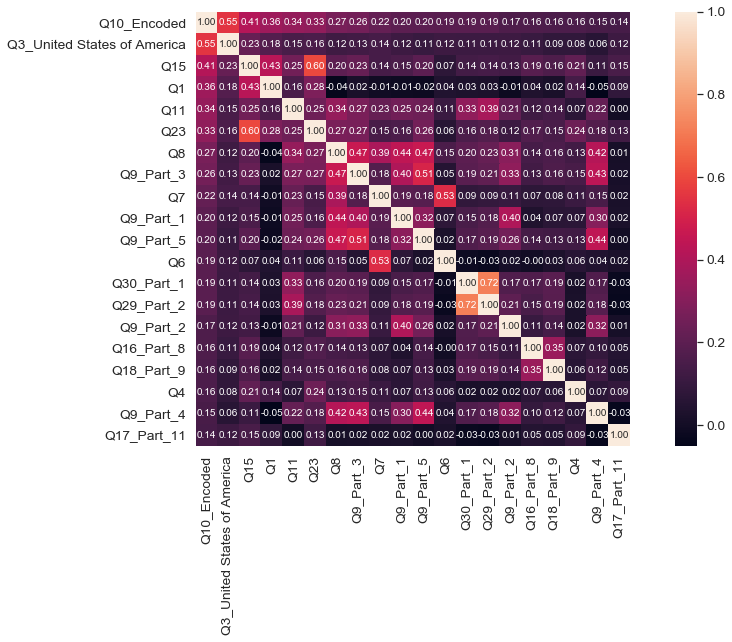

In [108]:
# Feature correlation matrix
k = 20 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = salaries.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'Q10_Encoded')['Q10_Encoded'].index
cm = np.corrcoef(salaries[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We confirm that country U.S.A is highly correlated with large salaries. Question 15 represents the length of years in which the individual has been coding, which intuitive makes sense as a predictor for salary. Question 1 is age, which also can be thought of as a measure of experience similar to Q15. Q11 and Q23 both ask how much the person/their company use machine learning models. Additional slighltly less correlated features include usage of machine learning models, employees responsibilities related to machine learning, size of company, and many more. This figure doesn't show which features are negatively correlated with salary, which can also be used as a strong predictor. We will explore this in section 3 using Lasso-Regularization.

# 3. Feature Selection

Feature engineering is a very important component of the machine learning pipeline. Feature engineering is the process of transforming the feature space of a model to improve accuracy. This includes some steps that have already been completed in this assignment, such as label-encoding categorical data, which is essential since machine learning models can't interpret non-numerical data. Another important part of feature engineering is feature scaling. This ensures that features of similar magnitude, so that the model weights (feature importance) aren't determined by arbitrary units or scaling factors. Additionally, feature engineering includes feature selection. This referes to both engineering new features, and dropping irrelevant ones. This reduces the model complexity which can lead to better generalization and faster computation times. 

Since our feature dimensions are quite high (~300), we would like to drop some useless features. We already saw through the correlation matrix some of the features that are indicative of salary. We will now take a more formal approach to feature selection by utilising Lasso-Regularization. We perform regularized regression and view the feature coefficients as a proxy for importance. We then drop the features whose weights have been set to zero.


In [109]:
# Using Lasso-Regularization for feature selection
salaries.drop(['Q10_buckets'],axis=1)
salaries.drop(['Q10'],axis=1)
from sklearn.metrics import make_scorer, r2_score, confusion_matrix
from sklearn import linear_model

y = salaries.Q10_Encoded
X = salaries.drop(['Q10_Encoded', 'Q10', 'Q10_buckets'], axis = 1)


lasso_reg = linear_model.Lasso(random_state=50)

# Set up parameter grid
param = {'alpha':[0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

acc_scorer_lm = make_scorer(r2_score)

# Run the grid search
gcv1 = GridSearchCV(lasso_reg, param, cv=10)
gcv1.fit(X, y)

lasso_reg_best = gcv1.best_estimator_  #Select best parameter combination

print('alpha (Constant that multiplies the L1 term):',gcv1.best_estimator_.alpha) 
print('normalize:',gcv1.best_estimator_.normalize)
lasso_reg_best.fit(X, y)
lasso_reg_best.score(X, y)
feature_coefs = sorted(list(zip(lasso_reg_best.coef_, X)),reverse=True)

# View feature coefficients
feature_coefs


alpha (Constant that multiplies the L1 term): 0.005
normalize: False


[(4.91926102247907, 'Q3_United States of America'),
 (3.822903017806554, 'Q3_Australia'),
 (3.8138879362023115, 'Q3_Switzerland'),
 (3.0211650239219, 'Q3_Israel'),
 (2.8194612225060527, 'Q3_Canada'),
 (2.3492578340851833, 'Q3_Germany'),
 (2.3331523032756754,
  'Q3_United Kingdom of Great Britain and Northern Ireland'),
 (1.9946870393283607, 'Q3_Denmark'),
 (1.9066041748462401, 'Q3_Norway'),
 (1.49760066639175, 'Q3_Netherlands'),
 (1.4264976552210251, 'Q3_Singapore'),
 (1.1767009254245888, 'Q3_New Zealand'),
 (1.121085704133549, 'Q3_France'),
 (0.867641319382378, 'Q3_Ireland'),
 (0.8444971180939085, 'Q3_Hong Kong (S.A.R.)'),
 (0.7173664144533987, 'Q5_Product/Project Manager'),
 (0.6864242520750861, 'Q3_Japan'),
 (0.647528090654587, 'Q3_Austria'),
 (0.42660999246934056, 'Q3_Sweden'),
 (0.4037245438506087, 'Q13_Part_7'),
 (0.39060715672661955, 'Q11'),
 (0.3021304826409324,
  'Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)'),
 (0.284563206348369, 'Q31_Part_2'),
 (0.2805599424

In [ ]:
# Drop Features
removed_feats = X.columns[(lasso_reg_best.coef_ == 0).ravel().tolist()]
X = X.drop(removed_feats, axis = 1)
X.head()

Again we see the importance of country in this model, as the majority of the top and bottom weights correspond to countries. We also see that countries with few responses are not good indicators of salary due to high variance. A large number of the subquestions are dropped as well, possibly because of the few responses. As a result, we have ~160 features, which means we've reduced the total number by approximately half. This constitutes the set of features which has direct correlation with salary prediction, so this justifies the use of the remaining features. We can now move on to model implementation.

# 4. Model Implementation

We will be performing ordinal logistic regression, which consists of a set of N-1 binary logistic regressions, where N is the number of target classes. The probabilities of each class can then be deduced using the probabilities from each binary classification.

In [ ]:
# Split into train/test sets
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_old)
X_test = scaler.transform(X_test_old)

# Run OVR just for comparison
model = LogisticRegression()    
model.fit(X_train, y_train_old)
pred = model.predict_proba(X_test)[:,0]
acc_ovr = model.score(X_test, y_test_old)
print('The OVR accuracy is: {}'.format(acc_ovr))

In [ ]:
# Ordinal Logistic Regression

# First we create dictionaries to map targets for each binary regression
dict0 = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict1 = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict2 = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict3 = {0:0, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict4 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict5 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict6 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict7 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict8 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1}
dict9 = {0:0, 1:0, 2:0, 3:1, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:1, 11:1, 12:1, 13:1, 14:1}
dict10 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:1, 12:1, 13:1, 14:1}
dict11 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:1, 13:1, 14:1}
dict12 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:1, 14:1}
dict13 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:1}


We compute cross-validation scores not on each individual classifier, but on the model as a whole.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Perform 10-Fold Cross Validation. We perform 14 binary logistic regression models, and use the results to extract
# probabilities for all 15 classes. We then find the maximum probability and assign the corresponding bucket as
# the prediction. The accuracy score is then computed.

pen = 'l2'

from sklearn.metrics import accuracy_score

kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_old)
np_idx = 0
accuracy = np.zeros(10)

for train_idx, val_idx in kfold.split(X_train_old):
    
    X_train, X_val = pd.DataFrame(X_train_old.values[train_idx]), pd.DataFrame(X_train_old.values[val_idx])
    y_train, y_val = pd.DataFrame(y_train_old.values[train_idx]), pd.DataFrame(y_train_old.values[val_idx])
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    probs = np.zeros([15, len(y_val)])

    # Round 0
    y_train0 = y_train.replace(dict0)
    y_val0 = y_val.replace(dict0)
    model0 = LogisticRegression(pen)    
    model0.fit(X_train, y_train0.values.ravel())
    pred0 = model0.predict_proba(X_val)[:,0]

    # Round 1
    y_train1 = y_train.replace(dict1)
    y_val1 = y_val.replace(dict1)
    model1 = LogisticRegression(pen)    
    model1.fit(X_train, y_train1.values.ravel())
    pred1 = model1.predict_proba(X_val)[:,0]

    # Round 2
    y_train2 = y_train.replace(dict2)
    y_val2 = y_val.replace(dict2)
    model2 = LogisticRegression(pen)    
    model2.fit(X_train, y_train2.values.ravel())
    pred2 = model2.predict_proba(X_val)[:,0]

    # Round 3
    y_train3 = y_train.replace(dict3)
    y_val3 = y_val.replace(dict3)
    model3 = LogisticRegression(pen)    
    model3.fit(X_train, y_train3.values.ravel())
    pred3 = model3.predict_proba(X_val)[:,0]

    # Round 4
    y_train4 = y_train.replace(dict4)
    y_val4 = y_val.replace(dict4)
    model4 = LogisticRegression(pen)    
    model4.fit(X_train, y_train4.values.ravel())
    pred4 = model4.predict_proba(X_val)[:,0]

    # Round 5
    y_train5 = y_train.replace(dict5)
    y_val5 = y_val.replace(dict5)
    model5 = LogisticRegression(pen)    
    model5.fit(X_train, y_train5.values.ravel())
    pred5 = model5.predict_proba(X_val)[:,0]

    # Round 6
    y_train6 = y_train.replace(dict6)
    y_val6 = y_val.replace(dict6)
    model6 = LogisticRegression(pen)    
    model6.fit(X_train, y_train6.values.ravel())
    pred6 = model6.predict_proba(X_val)[:,0]

    # Round 7
    y_train7 = y_train.replace(dict7)
    y_val7 = y_val.replace(dict7)
    model7 = LogisticRegression(pen)    
    model7.fit(X_train, y_train7.values.ravel())
    pred7 = model7.predict_proba(X_val)[:,0]

    # Round 8
    y_train8 = y_train.replace(dict8)
    y_val8 = y_val.replace(dict8)
    model8 = LogisticRegression(pen)    
    model8.fit(X_train, y_train8.values.ravel())
    pred8 = model8.predict_proba(X_val)[:,0]

    # Round 9
    y_train9 = y_train.replace(dict9)
    y_val9 = y_val.replace(dict9)
    model9 = LogisticRegression(pen)    
    model9.fit(X_train, y_train9.values.ravel())
    pred9 = model9.predict_proba(X_val)[:,0]

    # Round 10
    y_train10 = y_train.replace(dict10)
    y_val10 = y_val.replace(dict10)
    model10 = LogisticRegression(pen)    
    model10.fit(X_train, y_train10.values.ravel())
    pred10 = model10.predict_proba(X_val)[:,0]

    # Round 11
    y_train11 = y_train.replace(dict11)
    y_val11 = y_val.replace(dict11)
    model11 = LogisticRegression(pen)    
    model11.fit(X_train, y_train11.values.ravel())
    pred11 = model11.predict_proba(X_val)[:,0]

    # Round 12
    y_train12 = y_train.replace(dict12)
    y_val12 = y_val.replace(dict12)
    model12 = LogisticRegression(pen)    
    model12.fit(X_train, y_train12.values.ravel())
    pred12 = model12.predict_proba(X_val)[:,0]

    # Round 13
    y_train13 = y_train.replace(dict13)
    y_val13 = y_val.replace(dict13)
    model13 = LogisticRegression(pen)    
    model13.fit(X_train, y_train13.values.ravel())
    pred13 = model13.predict_proba(X_val)[:,0]
    
    # Compute overall predicted probabilities. We use clip to not allow slightly negative probabilities.
    # This results in the sum of all probilities being slightly higher than 1 in some instances.
    prob0 = pred0
    prob1 = (pred1 - pred0).clip(min=0)
    prob2 = (pred2 - pred1).clip(min=0)
    prob3 = (pred3 - pred2).clip(min=0)
    prob4 = (pred4 - pred3).clip(min=0)
    prob5 = (pred5 - pred4).clip(min=0)
    prob6 = (pred6 - pred5).clip(min=0)
    prob7 = (pred7 - pred6).clip(min=0)
    prob8 = (pred8 - pred7).clip(min=0)
    prob9 = (pred9 - pred8).clip(min=0)
    prob10 = (pred10 - pred9).clip(min=0)
    prob11 = (pred11 - pred10).clip(min=0)
    prob12 = (pred12 - pred11).clip(min=0)
    prob13 = (pred13 - pred12).clip(min=0)
    prob14 = (1 - pred13).clip(min=0)
    
    # Find maximum probability index for each sample
    probs = np.array([prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9, prob10, prob11, prob12, prob13, prob14])
    max_probs_index = np.argmax(probs, axis = 0)
    
    #probs_sum = probs.sum(axis = 0)
    # Calculate accuracy score
    ACC = accuracy_score(max_probs_index, y_val)
    accuracy[np_idx] = ACC*100     
    
    # Create dataframe of probabilities
    bucket_predictions = salaries.Q10_Encoded[val_idx].to_frame()
    bucket_predictions['prob_0'] = prob0
    bucket_predictions['prob_1'] = prob1
    bucket_predictions['prob_2'] = prob2
    bucket_predictions['prob_3'] = prob3
    bucket_predictions['prob_4'] = prob4
    bucket_predictions['prob_5'] = prob5
    bucket_predictions['prob_6'] = prob6
    bucket_predictions['prob_7'] = prob7
    bucket_predictions['prob_8'] = prob8
    bucket_predictions['prob_9'] = prob9
    bucket_predictions['prob_10'] = prob10
    bucket_predictions['prob_11'] = prob11
    bucket_predictions['prob_12'] = prob12
    bucket_predictions['prob_13'] = prob13
    bucket_predictions['prob_14'] = prob14


    prob_dict = {'prob_0': 0, 'prob_1': 1, 'prob_2': 2, 'prob_3': 3, 'prob_4': 4, 'prob_5': 5, 'prob_6': 6, 'prob_7': 7, 'prob_8': 8, 'prob_9': 9, 'prob_10': 10, 'prob_11': 11, 'prob_12': 12, 'prob_13': 13, 'prob_14': 14}
    bucket_predictions['predicted_bucket'] = bucket_predictions.drop('Q10_Encoded', axis = 1).idxmax(axis = 1)
    bucket_predictions['predicted_bucket'] = bucket_predictions['predicted_bucket'].replace(prob_dict)
          
    np_idx += 1
    

for i in range(10):
        print ("Fold {}: Accuracy: {}".format(i + 1, round(accuracy[i],3)))
        
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

From this initial model implementation, we can see that the model accuracy across the 10 folds is fairly consistent with a standard deviation of 0.96%. However, the bias for the model is quite high with an average accuracy score of 31.6%. The model was computed a few different hyperparameter values. I found that the 'lgfbs' solver was fastest, but the 'newton-cg' gave better accuracy. I also tried a few values of C at different orders of magnitude and found that C~1 gave the best accuracy. C acts as an inverse regularization strength (i.e. smaller C gives stronger regularization). In terms of bias variance tradeoff, a lower C value penalizes high weights, but may result in underfitting since the model can be too simple (low variance, high bias). High values of C will allow larger weights and may lead to overfitting, since the model will be highly tuned to the training set (high variance, low bias). I believe it is more likely that the model is underfitting since we have a low variance, but accuracy of ~30%. We will further tune these hyperparameters in part 5.

Also, by analyzing the results in the dataframe, I found that the majority of correct predictions came from the first salary bucket, which makes sense since it is composed with the largest number of responses. It was much more difficult for the model to correctly predict buckets in the middle (i.e. ~ 3 - 9). 

# 5. Model Tuning

We will use a grid search to find the optimal solver and regularization tradeoff parameter C. We choose to use the accuracy score performance measure, since this is multinomial classification. Alternatively, we could have used binary classification metrics (recall, precision) on the individual binary models, but we chose to tune the model as a whole and not on an individual model basis.

Note: The following gridsearch takes ~1hr to run, so it is commented out as per instructions. If you don't want to run it, the optimal hyperparamters are {C = 1.0, solver = 'newton-cg'} and the cross validation accuracy was 36.8% with standard deviation 1.6%.

In [ ]:
# UNCOMMENT THIS TO PERFORM THE GRIDSEARCH

# Set up Grid Search to find best hyperparamters
#kfold = KFold(n_splits=10)
#kfold.get_n_splits(X_train_old)

# Initialize best params
#best_params = {}
#best_accuracy = 0
#best_std = 0


#for C in [0.001, 0.01, 0.1, 1., 10., 100., 1000.]:
#    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
#        print(C, solver)
#        np_idx = 0
#        accuracy = np.zeros(10)

#        for train_idx, val_idx in kfold.split(X_train_old):

#            X_train, X_val = pd.DataFrame(X_train_old.values[train_idx]), pd.DataFrame(X_train_old.values[val_idx])
#            y_train, y_val = pd.DataFrame(y_train_old.values[train_idx]), pd.DataFrame(y_train_old.values[val_idx])

#            X_train = scaler.fit_transform(X_train)
#            X_val = scaler.transform(X_val)

#            probs = np.zeros([15, len(y_val)])

            # Round 0
#            y_train0 = y_train.replace(dict0)
#            y_val0 = y_val.replace(dict0)
#            model0 = LogisticRegression(C=C, solver=solver)    
#            model0.fit(X_train, y_train0.values.ravel())
#            pred0 = model0.predict_proba(X_val)[:,0]

            # Round 1
#            y_train1 = y_train.replace(dict1)
#            y_val1 = y_val.replace(dict1)
#            model1 = LogisticRegression(C=C, solver=solver)    
#            model1.fit(X_train, y_train1.values.ravel())
#            pred1 = model1.predict_proba(X_val)[:,0]

            # Round 2
#            y_train2 = y_train.replace(dict2)
#            y_val2 = y_val.replace(dict2)
#            model2 = LogisticRegression(C=C, solver=solver)    
#            model2.fit(X_train, y_train2.values.ravel())
#            pred2 = model2.predict_proba(X_val)[:,0]

            # Round 3
#            y_train3 = y_train.replace(dict3)
#            y_val3 = y_val.replace(dict3)
#            model3 = LogisticRegression(C=C, solver=solver)
#            model3.fit(X_train, y_train3.values.ravel())
#            pred3 = model3.predict_proba(X_val)[:,0]

            # Round 4
#            y_train4 = y_train.replace(dict4)
#            y_val4 = y_val.replace(dict4)
#            model4 = LogisticRegression(C=C, solver=solver)
#            model4.fit(X_train, y_train4.values.ravel())
#            pred4 = model4.predict_proba(X_val)[:,0]

            # Round 5
#            y_train5 = y_train.replace(dict5)
#            y_val5 = y_val.replace(dict5)
#            model5 = LogisticRegression(C=C, solver=solver)
#            model5.fit(X_train, y_train5.values.ravel())
#            pred5 = model5.predict_proba(X_val)[:,0]

            # Round 6
#            y_train6 = y_train.replace(dict6)
#            y_val6 = y_val.replace(dict6)
#            model6 = LogisticRegression(C=C, solver=solver)
#            model6.fit(X_train, y_train6.values.ravel())
#            pred6 = model6.predict_proba(X_val)[:,0]

            # Round 7
#            y_train7 = y_train.replace(dict7)
#            y_val7 = y_val.replace(dict7)
#            model7 = LogisticRegression(C=C, solver=solver)
#            model7.fit(X_train, y_train7.values.ravel())
#            pred7 = model7.predict_proba(X_val)[:,0]

            # Round 8
#            y_train8 = y_train.replace(dict8)
#            y_val8 = y_val.replace(dict8)
#            model8 = LogisticRegression(C=C, solver=solver)
#            model8.fit(X_train, y_train8.values.ravel())
#            pred8 = model8.predict_proba(X_val)[:,0]

            # Round 9
#            y_train9 = y_train.replace(dict9)
#            y_val9 = y_val.replace(dict9)
#            model9 = LogisticRegression(C=C, solver=solver)
#            model9.fit(X_train, y_train9.values.ravel())
#            pred9 = model9.predict_proba(X_val)[:,0]

            # Round 10
#            y_train10 = y_train.replace(dict10)
#            y_val10 = y_val.replace(dict10)
#            model10 = LogisticRegression(C=C, solver=solver) 
#            model10.fit(X_train, y_train10.values.ravel())
#            pred10 = model10.predict_proba(X_val)[:,0]

            # Round 11
#            y_train11 = y_train.replace(dict11)
#            y_val11 = y_val.replace(dict11)
#            model11 = LogisticRegression(C=C, solver=solver)
#            model11.fit(X_train, y_train11.values.ravel())
#            pred11 = model11.predict_proba(X_val)[:,0]

            # Round 12
#            y_train12 = y_train.replace(dict12)
#            y_val12 = y_val.replace(dict12)
#            model12 = LogisticRegression(C=C, solver=solver)
#            model12.fit(X_train, y_train12.values.ravel())
#            pred12 = model12.predict_proba(X_val)[:,0]

            # Round 13
#            y_train13 = y_train.replace(dict13)
#            y_val13 = y_val.replace(dict13)
#            model13 = LogisticRegression(C=C, solver=solver)
#            model13.fit(X_train, y_train13.values.ravel())
#            pred13 = model13.predict_proba(X_val)[:,0]

            # Compute overall predicted probabilities
#            prob0 = pred0
#            prob1 = (pred1 - pred0).clip(min=0)
#            prob2 = (pred2 - pred1).clip(min=0)
#            prob3 = (pred3 - pred2).clip(min=0)
#            prob4 = (pred4 - pred3).clip(min=0)
#            prob5 = (pred5 - pred4).clip(min=0)
#            prob6 = (pred6 - pred5).clip(min=0)
#            prob7 = (pred7 - pred6).clip(min=0)
#            prob8 = (pred8 - pred7).clip(min=0)
#            prob9 = (pred9 - pred8).clip(min=0)
#            prob10 = (pred10 - pred9).clip(min=0)
#            prob11 = (pred11 - pred10).clip(min=0)
#            prob12 = (pred12 - pred11).clip(min=0)
#            prob13 = (pred13 - pred12).clip(min=0)
#            prob14 = (1 - pred13).clip(min=0)

            # Find maximum probability index for each sample
#            probs = np.array([prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9, prob10, prob11, prob12, prob13, prob14])
#            max_probs_index = np.argmax(probs, axis = 0)

            #probs_sum = probs.sum(axis = 0)
            # Calculate accuracy score
#            ACC = accuracy_score(max_probs_index, y_val)
#            accuracy[np_idx] = ACC*100  
            
            
#            print(np_idx)
#            np_idx += 1
            
#        if np.mean(accuracy) > best_accuracy:
#            best_params = {'C':C, 'solver':solver}
#            best_accuracy = np.mean(accuracy)
#            best_std = np.std(accuracy)
        
#print ("Best Average Accuracy Score: {}%({}%)".format((best_accuracy,3),round(best_std,3)))

In [ ]:
#print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

Through hyperparamter tuning, we see that we are able to increase our accuracy by ~5% at the cost of slightly higher variance. The value of C remains the same as the default paramter, but the optimal solver has been changed to 'newton-cg'. Watching the grid search run, I noticed that the 'newton-cg' and 'saga' solvers took a significantly longer amount of time to fit the data than any of the other solvers. This increase in accuracy may be a tradeoff in computational time. We will now go forward and apply our optimal paramters to evaluate the test set.

# 6. Testing & Discussion

We now apply our optimal paramters, and compute classifications on the test set. Run the next line if you skipped the gridsearch.

In [ ]:
best_params = {'C':1.0, 'solver': 'newton-cg'}

In [ ]:
 # Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

probs = np.zeros([15, len(y_val)])

# Round 0
y_train0 = y_train.replace(dict0)
y_test0 = y_test.replace(dict0)
model0 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model0.fit(X_train, y_train0.values.ravel())
pred0 = model0.predict_proba(X_test)[:,0]

# Round 1
y_train1 = y_train.replace(dict1)
y_test1 = y_test.replace(dict1)
model1 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model1.fit(X_train, y_train1.values.ravel())
pred1 = model1.predict_proba(X_test)[:,0]

# Round 2
y_train2 = y_train.replace(dict2)
y_test2 = y_test.replace(dict2)
model2 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model2.fit(X_train, y_train2.values.ravel())
pred2 = model2.predict_proba(X_test)[:,0]

# Round 3
y_train3 = y_train.replace(dict3)
y_test3 = y_test.replace(dict3)
model3 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model3.fit(X_train, y_train3.values.ravel())
pred3 = model3.predict_proba(X_test)[:,0]

# Round 4
y_train4 = y_train.replace(dict4)
y_test4 = y_test.replace(dict4)
model4 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model4.fit(X_train, y_train4.values.ravel())
pred4 = model4.predict_proba(X_test)[:,0]

# Round 5
y_train5 = y_train.replace(dict5)
y_test5 = y_test.replace(dict5)
model5 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model5.fit(X_train, y_train5.values.ravel())
pred5 = model5.predict_proba(X_test)[:,0]

# Round 6
y_train6 = y_train.replace(dict6)
y_test6 = y_test.replace(dict6)
model6 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model6.fit(X_train, y_train6.values.ravel())
pred6 = model6.predict_proba(X_test)[:,0]

# Round 7
y_train7 = y_train.replace(dict7)
y_test7 = y_test.replace(dict7)
model7 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model7.fit(X_train, y_train7.values.ravel())
pred7 = model7.predict_proba(X_test)[:,0]

# Round 8
y_train8 = y_train.replace(dict8)
y_test8 = y_test.replace(dict8)
model8 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model8.fit(X_train, y_train8.values.ravel())
pred8 = model8.predict_proba(X_test)[:,0]

# Round 9
y_train9 = y_train.replace(dict9)
y_test9 = y_test.replace(dict9)
model9 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model9.fit(X_train, y_train9.values.ravel())
pred9 = model9.predict_proba(X_test)[:,0]

# Round 10
y_train10 = y_train.replace(dict10)
y_test10 = y_test.replace(dict10)
model10 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model10.fit(X_train, y_train10.values.ravel())
pred10 = model10.predict_proba(X_test)[:,0]

# Round 11
y_train11 = y_train.replace(dict11)
y_test11 = y_test.replace(dict11)
model11 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model11.fit(X_train, y_train11.values.ravel())
pred11 = model11.predict_proba(X_test)[:,0]

# Round 12
y_train12 = y_train.replace(dict12)
y_val12 = y_val.replace(dict12)
model12 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model12.fit(X_train, y_train12.values.ravel())
pred12 = model12.predict_proba(X_test)[:,0]

# Round 13
y_train13 = y_train.replace(dict13)
y_test13 = y_test.replace(dict13)
model13 = LogisticRegression(C=best_params['C'],solver=best_params['solver'])    
model13.fit(X_train, y_train13.values.ravel())
pred13 = model13.predict_proba(X_test)[:,0]

# Compute overall predicted probabilities
prob0 = pred0
prob1 = (pred1 - pred0).clip(min=0)
prob2 = (pred2 - pred1).clip(min=0)
prob3 = (pred3 - pred2).clip(min=0)
prob4 = (pred4 - pred3).clip(min=0)
prob5 = (pred5 - pred4).clip(min=0)
prob6 = (pred6 - pred5).clip(min=0)
prob7 = (pred7 - pred6).clip(min=0)
prob8 = (pred8 - pred7).clip(min=0)
prob9 = (pred9 - pred8).clip(min=0)
prob10 = (pred10 - pred9).clip(min=0)
prob11 = (pred11 - pred10).clip(min=0)
prob12 = (pred12 - pred11).clip(min=0)
prob13 = (pred13 - pred12).clip(min=0)
prob14 = (1 - pred13).clip(min=0)

# Find maximum probability index for each sample
probs = np.array([prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9, prob10, prob11, prob12, prob13, prob14])
max_probs_index = np.argmax(probs, axis = 0)

#probs_sum = probs.sum(axis = 0)
# Calculate accuracy score
ACC = accuracy_score(max_probs_index, y_test)
accuracy = ACC*100     


bucket_predictions = salaries.Q10_Encoded[y_test.index].to_frame()
bucket_predictions['prob_0'] = prob0
bucket_predictions['prob_1'] = prob1
bucket_predictions['prob_2'] = prob2
bucket_predictions['prob_3'] = prob3
bucket_predictions['prob_4'] = prob4
bucket_predictions['prob_5'] = prob5
bucket_predictions['prob_6'] = prob6
bucket_predictions['prob_7'] = prob7
bucket_predictions['prob_8'] = prob8
bucket_predictions['prob_9'] = prob9
bucket_predictions['prob_10'] = prob10
bucket_predictions['prob_11'] = prob11
bucket_predictions['prob_12'] = prob12
bucket_predictions['prob_13'] = prob13
bucket_predictions['prob_14'] = prob14


prob_dict = {'prob_0': 0, 'prob_1': 1, 'prob_2': 2, 'prob_3': 3, 'prob_4': 4, 'prob_5': 5, 'prob_6': 6, 'prob_7': 7, 'prob_8': 8, 'prob_9': 9, 'prob_10': 10, 'prob_11': 11, 'prob_12': 12, 'prob_13': 13, 'prob_14': 14}
bucket_predictions['predicted_bucket'] = bucket_predictions.drop('Q10_Encoded', axis = 1).idxmax(axis = 1)
bucket_predictions['predicted_bucket'] = bucket_predictions['predicted_bucket'].replace(prob_dict)

print('Test set accuracy is: {}%'.format(round(accuracy, 2)))

In [ ]:
bucket_predictions.head()

The test set accuracy of 36.56% is very similar to our accurcay on the training set, which indicates that our model generalizes well. As such, I do not believe that the model is overfitting. The accuracy is low, but it is tough too tell whether this is due to the inherrent difficulty in performing 15 class multinomial logistic regression or model deficiencies. Let's look at a 12x12 confusion matrix to better understand our results.

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, max_probs_index)

plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique().sort(), rotation=45, fontsize=12)
plt.yticks(tick_marks, y.unique().sort(), fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 290:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

The confusion matrix shows that the overwhelming majority of the correct classifications come from the lowest salary bucket, which was also the bucket that composed most of the responses. We see that as we move towards the middle buckets, the classification accuracy decreases significantly. However, we can also see the effect of performing ordinal logistic regression vs the ovr methodology. Looking at the predicted label of 0, we can see that the majority of the misclassifications are within salary buckets 1-5, meaning that the model only slightly misclassified the sample. If there were fewer targets (i.e. less buckets spanning larger salary ranges), then the accuracy may improve significantly. We also see a large spike at bucket 10, where there are a large number of classifications and misclassifications. If we look back to our distribution of salary buckets in the U.S.A., we see that bucket 10 has the highest count of responses. Therefore, the model may be predicting a large number of bucket 10's based on its frequency in developed countries. Let's look at the overall distribution of salary buckets for the predicted and actual targets.

In [ ]:
# Plot distributions of test set buckets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1 = sns.countplot(x = 'predicted_bucket', data = bucket_predictions, ax = ax1).set_title('Predicted Salary Distribution')
ax2 = sns.countplot(y_test, ax = ax2).set_title('Actual Salary Distribution')



Here we can see that the distributions roughly resemble one another. We notice that salary buckets that are near a high frequency bucket may get drowned out by its influence. For example, we significantly fewer bucket 1 predictions than the actual target, possibly because they are being misclassified as bucket 0. This plot may indicate underfitting, as the model seems to be oversimplifying the complexity involved with salary prediction. To improve results, we may want to go back and engineer new features that are indicative of middle salary buckets. We could also look at a subset of the data (i.e. only countries in North America and Europe), which remove some of the variability involved with the data. Overall, I believe the results and the accuracy are reasonable given the difficulty of predicting across 15 classes.

In [ ]:
# Here we can experiment by looking at the multinomial probabilities for each test sample
bucket_predictions[(bucket_predictions.predicted_bucket == 14) & (bucket_predictions.Q10_Encoded == 14)]